In [1]:
import pandas as pd
import cptac
import statistics as st
import cptac.utils as ut
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import transform_pval 
from scipy import stats
import scipy

In [2]:
ccrcc = cptac.Ccrcc()
en = cptac.Endometrial()
luad = cptac.Luad()
hnscc  = cptac.Hnscc()
lscc = cptac.Lscc()

cptac warning: The LSCC data is currently strictly reserved for CPTAC investigators. Otherwise, you are not authorized to access these data. Additionally, even after these data become publicly available, they will be subject to a publication embargo (see https://proteomics.cancer.gov/data-portal/about/data-use-agreement or enter cptac.embargo() to open the webpage for more details). (<ipython-input-2-5c25f03e6d4a>, line 5)


In [3]:
cancer_dict = {ccrcc:"ccrcc",en:"endometrial",luad:"luad", hnscc:"hnscc",lscc:"lscc"}
cancer_list = [ccrcc,en,luad,hnscc,lscc]

In [4]:
mutated_gene = 'TP53'

In [5]:
def get_omics_df(cancer):
    transcriptomics_df = cancer.get_transcriptomics(tissue_type='tumor')
    proteomics_df = cancer.get_proteomics(tissue_type='tumor')
    if isinstance(proteomics_df.columns, pd.MultiIndex):
        proteomics_df = proteomics_df.droplevel('Database_ID', axis = 1)
    if isinstance(transcriptomics_df.columns, pd.MultiIndex):
        transcriptomics_df = transcriptomics_df.droplevel('Database_ID', axis = 1)
    proteomics_df['patient_ID'] = proteomics_df.index
    transcriptomics_df['patient_ID'] = transcriptomics_df.index
    transcriptomics_df = transcriptomics_df.melt(id_vars='patient_ID', var_name = 'gene', value_name='transcriptomics')
    proteomics_df = proteomics_df.melt(id_vars='patient_ID', var_name = 'gene', value_name='proteomics')
    mutation_df = cancer.get_somatic_mutation()
    mutation_df = mutation_df[mutation_df.Gene == mutated_gene]
    omics_df = pd.merge(transcriptomics_df, proteomics_df, how = 'inner')
    omics_df['mutation_status'] = omics_df.patient_ID.isin(mutation_df.index)
    omics_df = omics_df.dropna()
    return omics_df

In [6]:
omics_dfs = []
for cancer in cancer_list:
    df = get_omics_df(cancer)
    df['cancer'] = [cancer_dict[cancer]] * len(df)
    omics_dfs.append(df)
omics_df = pd.concat(omics_dfs)

In [7]:
correlation_df = pd.read_csv('TP53_trans_effects.csv')

In [8]:
sig_correlation_changes = []
for cancer in pd.unique(correlation_df.cancer):
    df = correlation_df[correlation_df.cancer == cancer]
    df = df[df.delta_correlation_pval <= 0.05 / len(df)]
    sig_correlation_changes.append(df)
sig_correlation_change_df = pd.concat(sig_correlation_changes)

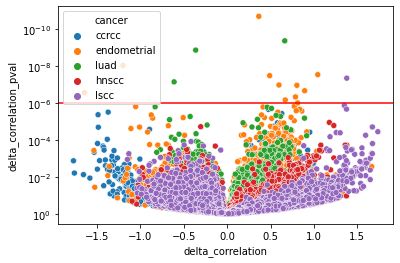

In [9]:
g = sns.scatterplot(data = correlation_df, x = 'delta_correlation', y = 'delta_correlation_pval', hue = 'cancer')
g.invert_yaxis()
g.set_yscale('log')
#for x,y,z in zip(sig_correlation_change_df['delta_correlation'], sig_correlation_change_df['delta_correlation_pval'], sig_correlation_change_df['gene']):
 #   plt.text(x = x, y = y * .9, s = z, color = 'black', rotation = 45)
plt.axhline(y = 0.05 / len(correlation_df), color = 'r')

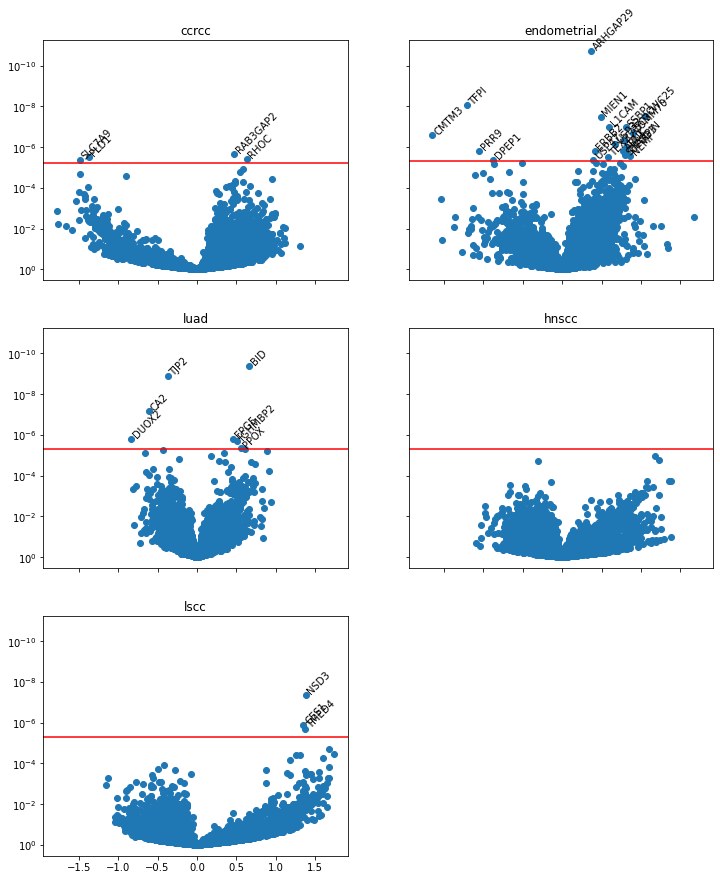

In [10]:
fig, axes = plt.subplots(nrows = 3, ncols = 2, sharex = True, sharey = True,
                        figsize=(12,15))
cancers = list(pd.unique(correlation_df.cancer))
fig.delaxes(axes[2,1])
for ax in axes.flatten():
    if len(cancers) == 0:
        break
    cancer = cancers[0]
    cancers.remove(cancer)
    df = correlation_df[correlation_df.cancer == cancer]
    sig_corr_change_df = sig_correlation_change_df[sig_correlation_change_df.cancer == cancer]
    plt.subplot(ax)
    plt.scatter(x = df.delta_correlation, y= df.delta_correlation_pval)
    ax.invert_yaxis()
    ax.set_yscale('log')
    for x,y,z in zip(sig_corr_change_df['delta_correlation'], sig_corr_change_df['delta_correlation_pval'], sig_corr_change_df['gene']):    
        plt.text(x = x, y = y * .9, s = z, color = 'black', rotation = 45)
    plt.axhline(y = 0.05 / len(df), color = 'r')
    plt.title(cancer)

In [11]:
sig_omics_dfs = []
for cancer in pd.unique(sig_correlation_change_df.cancer):
    cancer_sig_corr_change = sig_correlation_change_df[sig_correlation_change_df.cancer == cancer]
    cancer_omics_df = omics_df[omics_df.cancer==cancer]
    cancer_sig_omics_df = cancer_omics_df[cancer_omics_df.gene.isin(cancer_sig_corr_change.gene)]
    sig_omics_dfs.append(cancer_sig_omics_df)
sig_omics_df = pd.concat(sig_omics_dfs)

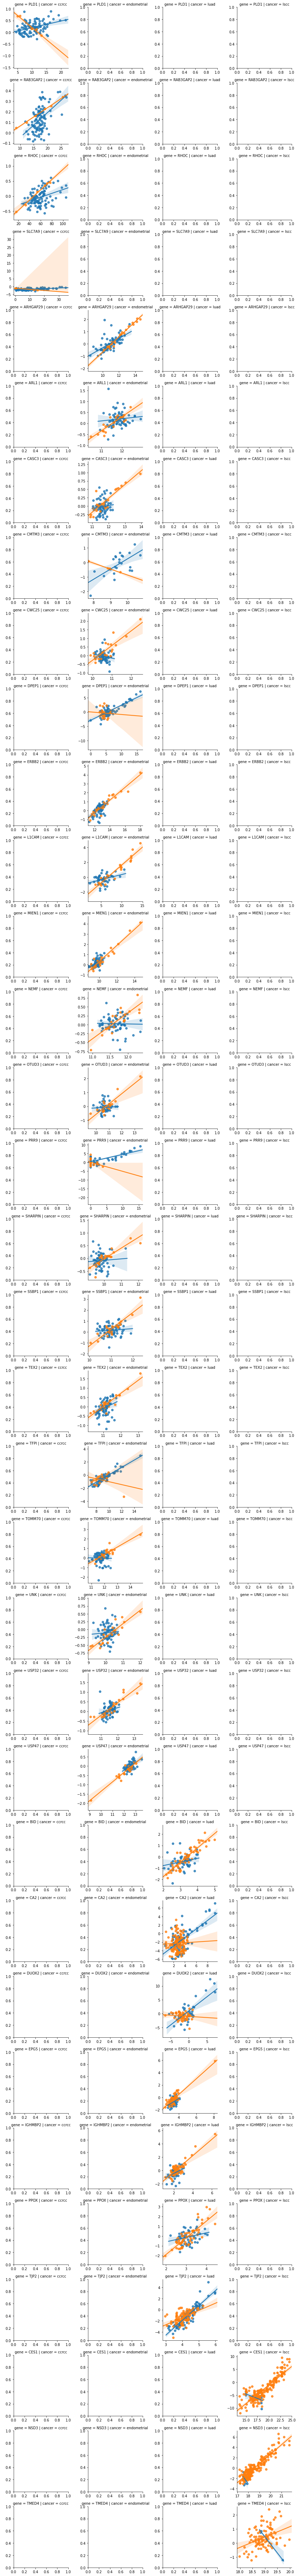

In [12]:
g = sns.FacetGrid(data = sig_omics_df, col = 'cancer', row = 'gene', hue = 'mutation_status', sharex = False, sharey = False)
g.map_dataframe(sns.regplot, x = 'transcriptomics', y = 'proteomics', fit_reg = True, truncate = False)

In [13]:
df1 = sig_correlation_change_df.melt(value_vars = ['non_mutated_correlation', 'mutated_correlation'], var_name = 'mutation_status', value_name = 'correlation', id_vars = ['gene', 'cancer']).replace(['non_mutated_correlation', 'mutated_correlation'], ['wt', 'mutated'])
df2 = sig_correlation_change_df.melt(value_vars = ['mutated_p_vals', 'non_mutated_p_vals'], value_name = 'p-val',var_name = 'mutation_status', id_vars = ['gene', 'cancer']).replace(['mutated_p_vals', 'non_mutated_p_vals'], ['mutated', 'wt'])
df = pd.merge(df1, df2)
significant_correlations = []
for index, row in df.iterrows():
    cancer = row['cancer']
    sig_corr = row['p-val'] <= 0.05 / sum(correlation_df.cancer == cancer)
    significant_correlations.append(sig_corr)
df['significant_correlation'] = sig_corr

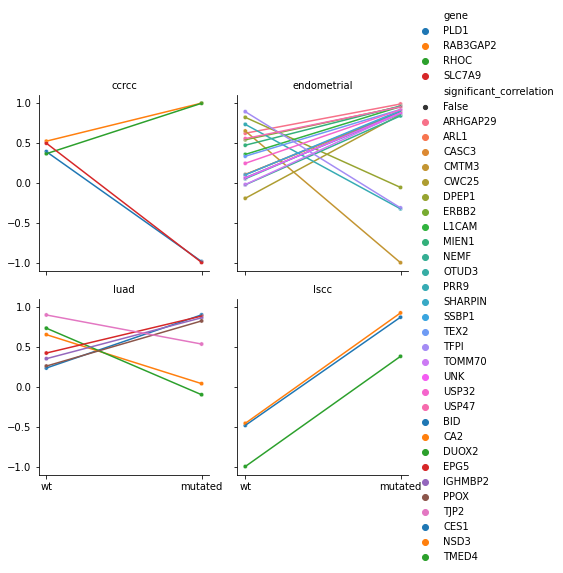

In [14]:
g = sns.FacetGrid(data = df, col = 'cancer', col_wrap = 2)
g.map_dataframe(sns.lineplot, x = 'mutation_status', y = 'correlation', hue = 'gene', legend = False)
g.map_dataframe(sns.scatterplot, x = 'mutation_status', y = 'correlation', hue = 'gene', size = 'significant_correlation')
#ax.legend(loc = 'center left', bbox_to_anchor=(1, 0.5))
g.set_titles('{col_name}')
g.add_legend()
#plt.title('TP53 Mutation Effects')